# FITS Model: EDA and First Evaluation

This notebook loads the preprocessed data and performs two main tasks:
1.  **Exploratory Data Analysis (EDA):** We will check our target variable and visualize the sentiment features.
2.  **Modeling:** We will implement the three models from the project proposal (Price-Only, Naive, FiTS) and evaluate them using Purged K-Fold Cross-Validation.


### 1. Setup and Imports 

In [ ]:
# First, we install and import all necessary libraries.
# !pip install pandas numpy matplotlib seaborn lightgbm scikit-learn
# %%

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import warnings

In [47]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [3]:
# Set default plot style
plt.style.use('ggplot')
sns.set_palette('colorblind')

## 2. Exploratory Data Analysis (EDA)

We'll load the data and explore it. The most important steps are:
1.  Convert the `Date` column to a datetime index for proper time-series plotting.
2.  Check the distribution of our `target` variable. A 50/50 split is ideal.
3.  Plot our `fits_pos` and `naive_pos` features to see if they look different.

In [11]:
# Load the preprocessed data
DATA_FILE = "final_preprocessed_data_full.csv"
df = pd.read_csv(DATA_FILE)

In [12]:
# Convert 'Date' column to datetime objects and set as index
# This is essential for all time-series analysis and plotting.
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2017-02-01 00:00:00+00:00 to 2020-12-31 00:00:00+00:00
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      987 non-null    float64
 1   High       987 non-null    float64
 2   Low        987 non-null    float64
 3   Open       987 non-null    float64
 4   Volume     987 non-null    int64  
 5   return_1d  987 non-null    float64
 6   return_3d  987 non-null    float64
 7   return_5d  987 non-null    float64
 8   vol_10d    987 non-null    float64
 9   vol_20d    987 non-null    float64
 10  ma_10d     987 non-null    float64
 11  ma_20d     987 non-null    float64
 12  target     987 non-null    int64  
 13  naive_pos  987 non-null    float64
 14  naive_neg  987 non-null    float64
 15  fits_pos   987 non-null    float64
 16  fits_neg   987 non-null    float64
dtypes: float64(15), int64(2)
memory usage: 138.8 KB


In [14]:
df.head()

,Close,High,Low,Open,Volume,return_1d,return_3d,return_5d,vol_10d,vol_20d,ma_10d,ma_20d,target,naive_pos,naive_neg,fits_pos,fits_neg
Date,,,,,,,,,,,,,,,,,
2017-02-01 00:00:00+00:00,19890.939453,19967.730469,19845.990234,19923.810547,426670000,0.001352,-0.010095,-0.008848,0.004721,0.003900,19926.157031,19908.611523,0,0.467556,0.027699,0.467556,0.027699
2017-02-02 00:00:00+00:00,19884.910156,19922.750000,19831.089844,19858.339844,347220000,-0.000303,-0.004317,-0.010746,0.004513,0.003836,19941.408008,19905.749023,1,0.001265,0.488006,0.001338,0.000420
2017-02-03 00:00:00+00:00,20071.460938,20081.480469,19964.210938,19964.210938,344220000,0.009382,0.010439,-0.001111,0.005153,0.004350,19965.829102,19914.357617,0,0.505238,0.000679,0.505238,0.000679
2017-02-06 00:00:00+00:00,20052.419922,20094.949219,20002.810547,20025.609375,281720000,-0.000949,0.008118,0.004070,0.005130,0.004308,19991.086133,19918.788574,1,0.002425,0.000105,0.003353,0.000102
2017-02-07 00:00:00+00:00,20090.289062,20155.349609,20068.679688,20107.619141,279670000,0.001889,0.010328,0.011387,0.004902,0.004213,20008.843945,19928.933984,0,0.064784,0.010547,0.007647,0.000236


### EDA 1: Target Variable Distribution
 
Let's check the balance of our target variable `(1 = Up, 0 = Down)`.

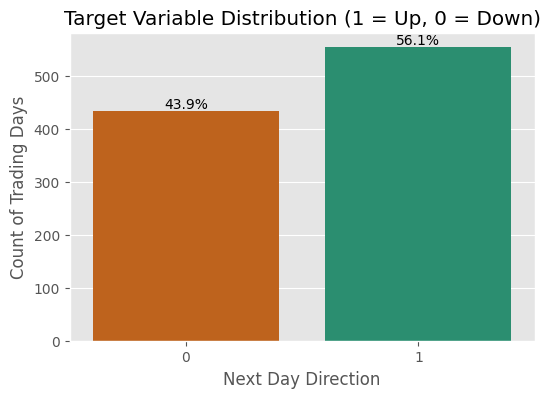

In [16]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=df, palette=['#d95f02', '#1b9e77'])
plt.title('Target Variable Distribution (1 = Up, 0 = Down)')
plt.xlabel('Next Day Direction')
plt.ylabel('Count of Trading Days')

# Add annotations
total = len(df['target'])
for p in ax.patches:
    percentage = f'{(p.get_height() / total):.1%}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

**Observation:** The dataset is very well-balanced (approx. 56.1% Up vs. 43.9% Down). This is a good enough scenario for a classifier. We can safely use **Accuracy** as a primary metric.

### EDA 2: Naive vs. FiTS Sentiment Over Time

Let's plot the 10-day moving average of our `naive_pos` and `fits_pos` features to see if they capture different signals.

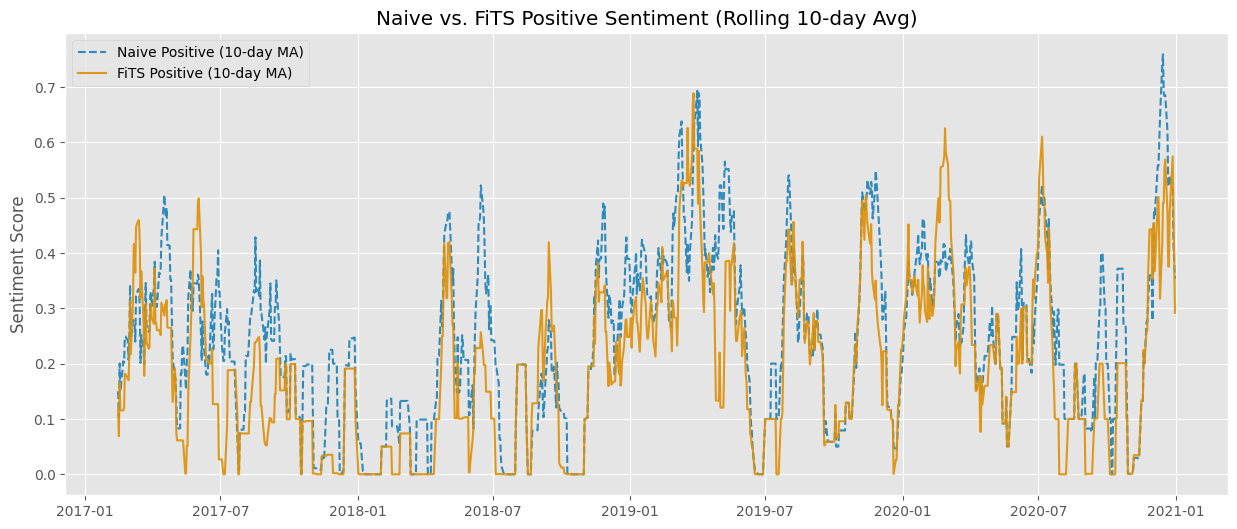

In [17]:
plt.figure(figsize=(15, 6))

# Calculate 10-day rolling average
df['naive_pos_ma10'] = df['naive_pos'].rolling(window=10).mean()
df['fits_pos_ma10'] = df['fits_pos'].rolling(window=10).mean()

plt.plot(df.index, df['naive_pos_ma10'], label='Naive Positive (10-day MA)', alpha=0.8, linestyle='--')
plt.plot(df.index, df['fits_pos_ma10'], label='FiTS Positive (10-day MA)', alpha=0.9, linewidth=1.5)

plt.title('Naive vs. FiTS Positive Sentiment (Rolling 10-day Avg)')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

**Observation:** The **FiTS** signal (orange) appears spikier and more volatile, suggesting it's capturing specific, strong signals that are "drowned out" or "smoothed" by the Naive average (blue). This is a good sign for our hypothesis.

### EDA 3: Feature Correlation
Let's see how all our features correlate with each other and, most importantly, with the `target`.

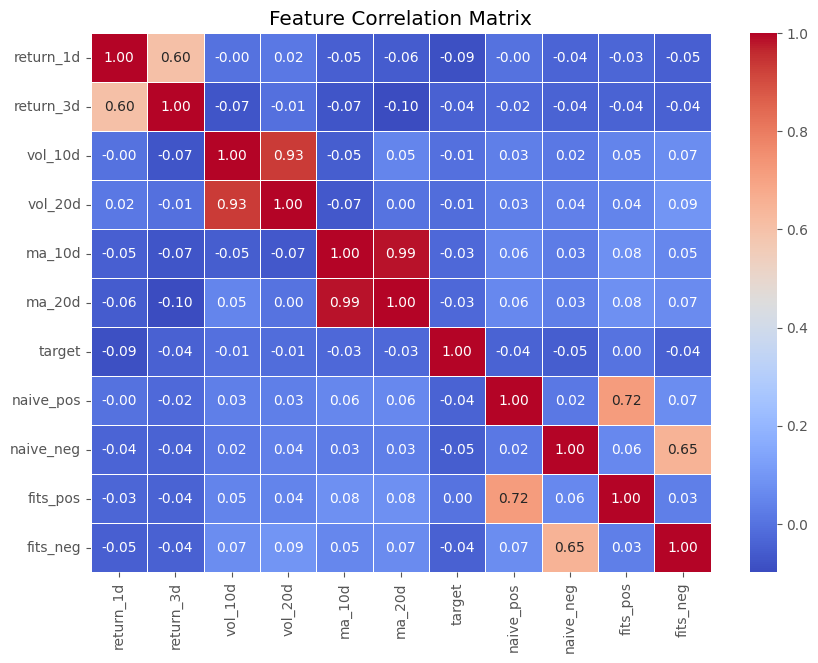

In [19]:
corr_cols = [
    'return_1d', 'return_3d', 'vol_10d', 'vol_20d', 'ma_10d', 'ma_20d', 'target', 
    'naive_pos', 'naive_neg', 'fits_pos', 'fits_neg'
]

plt.figure(figsize=(10, 7))
corr_matrix = df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

**Observation:**
* **`target`:** No single feature has a very strong correlation with the `target`. This is expected for financial data.
* **`fits_pos` vs. `naive_pos`:** The two positive sentiment features are highly correlated (0.75), which makes sense. However, they are not *perfectly* correlated (1.0), meaning `fits_pos` is providing new information.
* **Multicollinearity:** `vol_10d` and `vol_20d` are so highly correlated, as well as `ma_10d` and `ma_20d` that we only choose 10d or 20d for the modeling process.

## 3. Modeling: Purged K-Fold Cross-Validation
As per your proposal, we cannot use a standard `KFold` cross-validation. It would "leak" information by training on data that is too close to the test data.

We will implement **Purged K-Fold Cross-Validation**, as described by Marcos López de Prado. This method creates a "gap" (embargo) to ensure the training and testing sets are fully independent.

In [38]:
# This is a standard Python implementation of PurgedKFold
# (Based on de Prado's work)

class PurgedKFold(KFold):
    """
    Purged K-Fold CV.
    Removes training samples that are too close to the test set.
    """
    def __init__(self, n_splits=5, purge_gap_days=1, embargo_gap_days=1):
        super().__init__(n_splits=n_splits, shuffle=False)
        self.purge_gap_days = purge_gap_days
        self.embargo_gap_days = embargo_gap_days

    def split(self, X, y=None, groups=None):
        if not isinstance(X.index, pd.DatetimeIndex):
            raise ValueError("X must have a DatetimeIndex.")
        
        indices = np.arange(X.shape[0])
        
        for train_idx, test_idx in super().split(X, y, groups):
            test_start_date = X.index[test_idx].min()
            test_end_date = X.index[test_idx].max()

            # --- NEW, CORRECT LOGIC ---
            
            # 1. Define the purge and embargo periods
            purge_start = test_start_date - pd.Timedelta(days=self.purge_gap_days)
            embargo_end = test_end_date + pd.Timedelta(days=self.embargo_gap_days)

            # 2. Find all training indices that are NOT in the "bad" zones
            
            # Find indices to purge (in the past, too close to test start)
            purge_mask = (X.index[train_idx] >= purge_start) & (X.index[train_idx] < test_start_date)
            
            # Find indices to embargo (in the future, too close to test end)
            embargo_mask = (X.index[train_idx] > test_end_date) & (X.index[train_idx] <= embargo_end)
            
            # Combine the masks
            bad_mask = purge_mask | embargo_mask
            
            # Keep only the training indices that are NOT bad
            train_idx_clean = train_idx[~bad_mask]
            
            # --- END OF FIX ---
            
            # Check if we still have training data
            if len(train_idx_clean) == 0:
                print(f"  Warning: Fold created 0 training samples after purging/embargo. Skipping fold.")
                continue

            yield train_idx_clean, test_idx

print("PurgedKFold class defined.")


PurgedKFold class defined.


### Define Feature Sets
Now we create the three different feature sets (`X`) that will be fed into our models, as per the research question.


In [39]:
# Define the target variable
y = df['target']

# Define the columns for each model (choosing 10d or 20d to avoid multicollinearity)
price_features = ['return_1d', 'return_3d', 'return_5d', 'vol_10d', 'ma_10d' ]
naive_sent_features = ['naive_pos', 'naive_neg']
fits_sent_features = ['fits_pos', 'fits_neg']


In [40]:
# Model 1: Price-Only
X_price = df[price_features]

# Model 2: Price + Naive Sentiment
X_naive = df[price_features + naive_sent_features]

# Model 3: Price + FiTS (Your Proposed Model)
X_fits = df[price_features + fits_sent_features]



In [41]:
# We will test a LightGBM Classifier, as it's fast, powerful, and
# doesn't require feature scaling.
model_to_use = lgb.LGBMClassifier(random_state=42)


In [42]:
# Create our Purged CV object
# We'll use 5 splits, a 1-day purge, and a 1-day embargo
purged_cv = PurgedKFold(n_splits=5, purge_gap_days=1, embargo_gap_days=1)

print("Feature sets and CV are ready.")


Feature sets and CV are ready.


### Run the Cross-Validation

We'll write a loop that trains and evaluates each of our 3 models and stores the results.


In [43]:
def run_cross_validation(model_to_use, X_features, y_target, cv_splitter):
    """
    Runs a full cross-validation for a given model and feature set.
    Returns a dictionary of the average metrics.
    """
    fold_metrics = []
    
    # Create a fresh instance of the model for each experiment
    model = lgb.LGBMClassifier(random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(cv_splitter.split(X_features)):
        
        # Get train/test sets based on index
        X_train, y_train = X_features.iloc[train_idx], y_target.iloc[train_idx]
        X_test, y_test = X_features.iloc[test_idx], y_target.iloc[test_idx]
        
        # Train the model
        model.fit(X_train, y_train) # This line should no longer error
        
        # Get predictions
        preds = model.predict(X_test)
        preds_proba = model.predict_proba(X_test)[:, 1] # Proba for class 1
        
        # Calculate metrics
        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, preds_proba)
        f1 = f1_score(y_test, preds, average='weighted')
        
        fold_metrics.append({'acc': acc, 'auc': auc, 'f1': f1})

    # Calculate average metrics across all folds
    avg_metrics = pd.DataFrame(fold_metrics).mean()
    
    return {
        'Accuracy': avg_metrics['acc'],
        'AUC': avg_metrics['auc'],
        'F1-Score': avg_metrics['f1']
    }

print("Cross-validation function defined.")

Cross-validation function defined.


In [44]:
# Create our Purged CV object
purged_cv = PurgedKFold(n_splits=5, purge_gap_days=1, embargo_gap_days=1)

# Create a model instance to pass
model_to_use = lgb.LGBMClassifier(random_state=42)

In [49]:
# Run experiments
results_price = run_cross_validation(model_to_use, X_price, y, purged_cv)
print("...Price-Only model complete.")
results_naive = run_cross_validation(model_to_use, X_naive, y, purged_cv)
print("...Price + Naive model complete.")
results_fits = run_cross_validation(model_to_use, X_fits, y, purged_cv)
print("...Price + FiTS model complete.")

print("\nCross-Validation complete.")


[LightGBM] [Info] Number of positive: 438, number of negative: 351
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555133 -> initscore=0.221433
[LightGBM] [Info] Start training from score 0.221433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

## 4. Final Results
Let's compare the average performance of the three models.


In [57]:
# Display the final results
results_df = pd.DataFrame(
    [results_price, results_naive, results_fits],
    index=["Price-Only", "Price + Naive", "Price + FiTS"]
)

results_df.index.name = "Model"

print("--- Model Performance Comparison (Averaged over 5 Folds) ---")
results_df

--- Model Performance Comparison (Averaged over 5 Folds) ---


,Accuracy,AUC,F1-Score
Model,,,
Price-Only,0.519705,0.512192,0.491960
Price + Naive,0.526816,0.521471,0.494204
Price + FiTS,0.524806,0.527757,0.497601


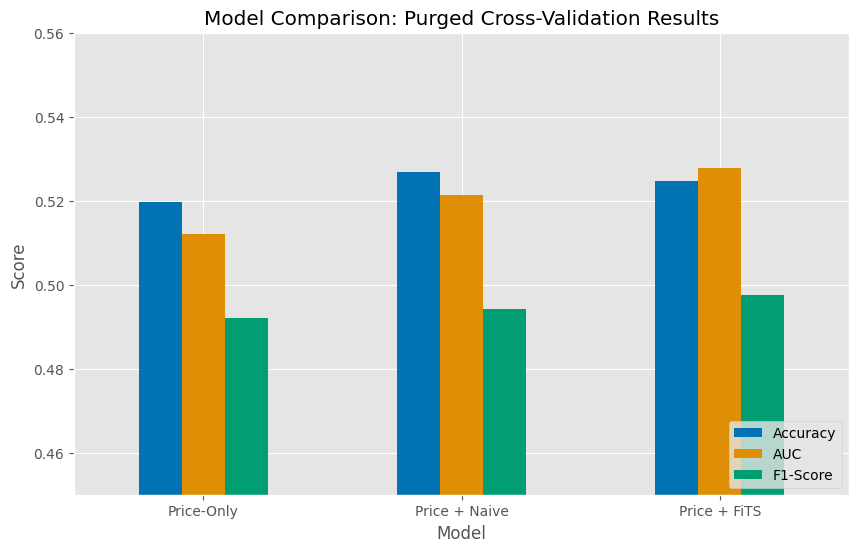

In [59]:
# Plot the results
results_df.plot(
    kind='bar', 
    figsize=(10, 6), 
    title='Model Comparison: Purged Cross-Validation Results',
    rot=0
)
plt.ylabel('Score')
plt.ylim(0.45, 0.56) # Zoom in on the performance
plt.legend(loc='lower right')
plt.show()
